## Load Data and Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import random
from dave import Dave
from datetime import datetime
from sklearn.decomposition import TruncatedSVD, MiniBatchSparsePCA
from datetime import datetime
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

reco = Dave.load_model('dave_rec_edition')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
movies = pd.read_csv("ml-latest-small/movies.csv")
s = movies.genres.str.split("|")
tmp = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
tmp = tmp.astype("category")
movies = pd.concat([movies,tmp], axis = 1)
movies =movies.drop("genres", axis = 1)
movies.head()

<ipython-input-2-5c0e7aba3517>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tmp = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Proposal

- If User has < 25 Movies; Recommend Movies based on Reinforced Learning 
- Take the matrix factorization method, and implement SGD to derive the parameters;

## Reccomender Edition


In [4]:
titles = pd.read_csv("ml-latest-small\movies.csv")
titles_comp = pd.read_csv("ml-latest-small\movies.csv")
titles_comp['title_noyear'] = titles_comp['title'].str[:-7]

ratings_year = []
ratings_noyear = []

#User 1
for page_num in range(1,12):
    if page_num == 1:
        page = requests.get("https://letterboxd.com/will_fisher/films/",timeout=5)
    else:
        page = requests.get("https://letterboxd.com/will_fisher/films/page/"+str(page_num)+"/",timeout=5)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    data = soup.find(class_='poster-list -p70 -grid film-list clear')
    data.find_all("div")
    example = data.find_all("li")
    for i in range(0,len(example)):
        title = example[i].find("div").find_all("img")[0]['alt']
        
        rating = example[i].find_all("span")
        if len(rating) != 2 and rating[2].text != "":
            score = len(rating[2].text) if rating[2].text[-1] != "½" else len(rating[2].text) - 0.5
            
            year = example[i].find("div")['data-film-slug'][-5:-1]
            regex = "^[12][0-9]{3}$"
            if re.match(regex, year):
                ratings_year.append([title +" ("+ year +")", score])
            else:
                ratings_noyear.append([title, score])
            
ratings_year = pd.DataFrame(ratings_year, columns=['title', 'rating'])
ratings_noyear = pd.DataFrame(ratings_noyear, columns=['title_noyear', 'rating'])

merged = pd.merge(titles_comp, ratings_year, on='title')
matched = merged["title"].tolist()
titles_comp = titles_comp[~titles_comp.title.isin(matched)]

merged2 = pd.merge(titles_comp, ratings_noyear, on='title_noyear')

user_ratings = pd.concat([merged, merged2], ignore_index=True).drop(["title_noyear"], axis=1)

user_movieIds = user_ratings["movieId"].tolist()
user_ratings = user_ratings.sample(frac=1).reset_index(drop=True)
user_ratings_orig1 = user_ratings.copy()
dict_ratings = user_ratings.groupby(by="rating").size().to_dict()
dict_ratings_before = dict_ratings.copy()
dict_ratings_before

{0.5: 15,
 1.0: 31,
 1.5: 27,
 2.0: 55,
 2.5: 55,
 3.0: 72,
 3.5: 61,
 4.0: 56,
 4.5: 37,
 5.0: 20}

In [6]:
userId = reco.add_user()
movies = list(reco.movies.index)
actions = reco.get_actions(movies,user_movieIds)

reco.Q.loc[userId, actions] = np.nan

print(f'Sum of NAs: {reco.Q[(userId-1):].isna().sum(axis=1)}')

Sum of NAs: 611    9313
dtype: int64


In [7]:
id_list = user_ratings["movieId"].tolist()
average = user_ratings["rating"].mean()
count = 0

print(f'User Database has Average Rating of {average}')

input = user_ratings.head(1)
user_ratings = user_ratings.iloc[1:]
for index, row in input.iterrows():
    reco.rewards(userId = userId, rating = row['rating'], movie_rated = row['movieId'])
    dict_ratings[row['rating']] -= 1
    count += 1
        
while count <= 100:
       
    print(f'Recommendation with {count} Movies')
    
    max_val = reco.Q.loc[userId].max()
    
    recommended = reco.recommend(userId, 5)
     
    rec = random.choice(recommended)
    score = user_ratings.loc[user_ratings['movieId'] == rec]['rating'].iloc[0]
    reco.rewards(userId = userId, rating = score, movie_rated = rec)
    user_ratings = user_ratings.drop(user_ratings[user_ratings.movieId == rec].index)
    count += 1
    dict_ratings[score] -= 1
            
    print(f'Recommended Movie had Rating: {score}')
    avg = user_ratings['rating'].mean()
    print(f'Average Rating Remaining In Database: {avg}')

User Database has Average Rating of 2.9055944055944054
Recommendation with 1 Movies
User recommendations
Recommended Movie had Rating: 3.5
Average Rating Remaining In Database: 2.9004683840749412
Recommendation with 2 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.897887323943662
Recommendation with 3 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.895294117647059
Recommendation with 4 Movies
User recommendations
Recommended Movie had Rating: 4.5
Average Rating Remaining In Database: 2.891509433962264
Recommendation with 5 Movies
User recommendations
Recommended Movie had Rating: 5.0
Average Rating Remaining In Database: 2.8865248226950353
Recommendation with 6 Movies
User recommendations
Recommended Movie had Rating: 3.5
Average Rating Remaining In Database: 2.8850710900473935
Recommendation with 7 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Rem

C:\Users\chann\CP421\Project\dave.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_grp["Count"] = 1


Recommended Movie had Rating: 5.0
Average Rating Remaining In Database: 2.8653846153846154
Recommendation with 13 Movies
User recommendations
Recommended Movie had Rating: 3.5
Average Rating Remaining In Database: 2.863855421686747
Recommendation with 14 Movies
User recommendations
Recommended Movie had Rating: 3.5
Average Rating Remaining In Database: 2.86231884057971
Recommendation with 15 Movies
popular well-rated movies
Recommended Movie had Rating: 5.0
Average Rating Remaining In Database: 2.857142857142857
Recommendation with 16 Movies
User recommendations
Recommended Movie had Rating: 2.5
Average Rating Remaining In Database: 2.858009708737864
Recommendation with 17 Movies
User recommendations
Recommended Movie had Rating: 3.0
Average Rating Remaining In Database: 2.8576642335766422
Recommendation with 18 Movies
User recommendations
Recommended Movie had Rating: 4.5
Average Rating Remaining In Database: 2.8536585365853657
Recommendation with 19 Movies
User recommendations
Recomm

Recommended Movie had Rating: 4.5
Average Rating Remaining In Database: 2.7374301675977653
Recommendation with 71 Movies
User recommendations
Recommended Movie had Rating: 4.5
Average Rating Remaining In Database: 2.7324929971988796
Recommendation with 72 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.728932584269663
Recommendation with 73 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.7253521126760565
Recommendation with 74 Movies
User recommendations
Recommended Movie had Rating: 2.5
Average Rating Remaining In Database: 2.725988700564972
Recommendation with 75 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.7223796033994336
Recommendation with 76 Movies
User recommendations
Recommended Movie had Rating: 4.0
Average Rating Remaining In Database: 2.71875
Recommendation with 77 Movies
User recommendations
Recommended Movie h

0.7920792079207921 % of Predictions above users average rating
   Rating  Count
0     0.5      0
1     1.0      2
2     1.5      5
3     2.0      4
4     2.5     10
5     3.0     11
6     3.5     10
7     4.0     24
8     4.5     23
9     5.0     12
   Rating    Percent
0     0.5   0.000000
1     1.0   6.451613
2     1.5  18.518519
3     2.0   7.272727
4     2.5  18.181818
5     3.0  15.277778
6     3.5  16.393443
7     4.0  42.857143
8     4.5  62.162162
9     5.0  60.000000


<AxesSubplot:xlabel='Rating'>

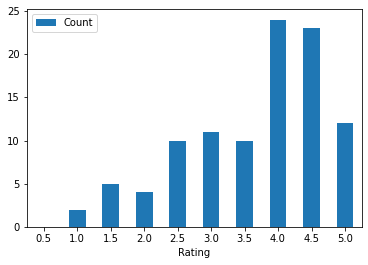

In [8]:
value = { k :dict_ratings_before[k] - dict_ratings[k] for k in dict_ratings.keys()}
predicted_total = pd.DataFrame.from_dict(value, orient='index', columns=['Count']).rename_axis('Rating').reset_index()

value = { k : (1-dict_ratings[k]/dict_ratings_before[k])*100 for k in dict_ratings.keys()}
predicted_percent = pd.DataFrame.from_dict(value, orient='index', columns=['Percent']).rename_axis('Rating').reset_index()

above = predicted_total[predicted_total["Rating"] >= average]["Count"].sum()
total = predicted_total["Count"].sum()

print(f'{above/total} % of Predictions above users average rating')
print(predicted_total)
print(predicted_percent)
predicted_total["Rating"] = predicted_total["Rating"].astype("string")
predicted_total.plot.bar(x="Rating", y="Count", rot=0)

Reinforced Recommenders results for recommending movies to one user

## Experiment

To demonstrate the effectiveness of your proposal, you are supposed to compare your method with multiple baselines.  Youcan start with some simple methods listed below.
- Use the global mean to do the prediction

In [9]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, shuffle=False)

In [10]:
sum1=(sum((ratings_test['rating']-ratings_test['rating'].mean())*(ratings_test['rating']-ratings_test['rating'].mean())))
sum1**(1/2)

150.60495551425043

- Use the user means as the prediction

In [11]:
series1=ratings_test.groupby(by='userId').mean()['rating']
ratings2=ratings_test
ratings3=ratings2.merge(series1,on='userId')
sum2=sum((ratings3['rating_x']-ratings3['rating_y'])*(ratings3['rating_x']-ratings3['rating_y']))
sum2**(1/2)

132.37334804225267

- Use the item means as the prediction;

In [12]:
series2=ratings_test.groupby(by='movieId').mean()['rating']
ratings2_movie=ratings_test
ratings3_movie=ratings2_movie.merge(series2,on='movieId')
sum3=sum((ratings3_movie['rating_x']-ratings3_movie['rating_y'])*(ratings3_movie['rating_x']-ratings3_movie['rating_y']))
sum3**(1/2)

112.0602070351093

- Use the classic method discussed in class

In [13]:
ratings_cf=ratings.drop(columns='timestamp')

In [14]:
ratings_cf

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [15]:
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset

In [16]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_cf[['userId', 'movieId', 'rating']], reader)

In [17]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8798  0.8727  0.8768  0.8714  0.8713  0.8744  0.0034  
MAE (testset)     0.6751  0.6707  0.6743  0.6669  0.6706  0.6715  0.0029  
Fit time          3.75    4.00    4.29    4.05    3.95    4.01    0.17    
Test time         0.12    0.17    0.14    0.12    0.11    0.13    0.02    


{'test_rmse': array([0.87984661, 0.87266809, 0.87684911, 0.87143518, 0.87134989]),
 'test_mae': array([0.67506278, 0.67070554, 0.67432879, 0.66687923, 0.67063843]),
 'fit_time': (3.7529845237731934,
  3.997562885284424,
  4.292055368423462,
  4.0510969161987305,
  3.948551654815674),
 'test_time': (0.11999773979187012,
  0.1700000762939453,
  0.13951587677001953,
  0.11900067329406738,
  0.10599875450134277)}

In [18]:
algo2=NMF()
cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9235  0.9196  0.9197  0.9178  0.9210  0.9203  0.0019  
MAE (testset)     0.7060  0.7056  0.7040  0.7043  0.7038  0.7048  0.0009  
Fit time          5.37    5.44    5.68    5.79    5.07    5.47    0.25    
Test time         0.11    0.09    0.12    0.22    0.09    0.13    0.05    


{'test_rmse': array([0.92346454, 0.91955153, 0.91969126, 0.91780717, 0.9210142 ]),
 'test_mae': array([0.70597733, 0.7056068 , 0.70403007, 0.70431249, 0.70384944]),
 'fit_time': (5.3670244216918945,
  5.43816614151001,
  5.684315204620361,
  5.7935075759887695,
  5.073516130447388),
 'test_time': (0.11499643325805664,
  0.09400320053100586,
  0.12199926376342773,
  0.22499895095825195,
  0.08700251579284668)}

In [19]:
algo3=KNNBasic()
cross_validate(algo3, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9331  0.9533  0.9468  0.9486  0.9536  0.9471  0.0075  
MAE (testset)     0.7157  0.7306  0.7264  0.7256  0.7288  0.7254  0.0052  
Fit time          0.15    0.16    0.16    0.16    0.15    0.15    0.01    
Test time         1.36    1.36    1.35    1.34    1.32    1.34    0.01    


{'test_rmse': array([0.93312026, 0.95331235, 0.94682452, 0.94863546, 0.9536253 ]),
 'test_mae': array([0.71567318, 0.73058456, 0.72641338, 0.72563223, 0.72881634]),
 'fit_time': (0.14699912071228027,
  0.1625533103942871,
  0.1550002098083496,
  0.156996488571167,
  0.14899897575378418),
 'test_time': (1.3557496070861816,
  1.3555676937103271,
  1.3545446395874023,
  1.3369998931884766,
  1.31986403465271)}

### Tuned SVD (Final Model)

In [20]:
algo = SVD(n_factors=150, n_epochs=75, lr_all=0.01, reg_all = 0.1)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8499  0.8457  0.8471  0.8482  0.8544  0.8490  0.0030  
MAE (testset)     0.6501  0.6498  0.6489  0.6509  0.6547  0.6509  0.0020  
Fit time          17.78   18.26   17.78   17.67   17.75   17.85   0.21    
Test time         0.21    0.11    0.20    0.11    0.20    0.17    0.05    


{'test_rmse': array([0.84990195, 0.84566495, 0.84707007, 0.84816718, 0.8544363 ]),
 'test_mae': array([0.65008755, 0.64978599, 0.64894538, 0.65087925, 0.65469556]),
 'fit_time': (17.777424335479736,
  18.25539255142212,
  17.78200078010559,
  17.66977882385254,
  17.74699902534485),
 'test_time': (0.2110002040863037,
  0.10799956321716309,
  0.19999933242797852,
  0.10900235176086426,
  0.19700050354003906)}

### Cold Start

In [21]:
from surprise import accuracy

#User cold start
def test_cold_start_pred(train, test, ratings):
    reader = Reader(rating_scale=(0.5, 5.0))
    # The columns must correspond to user id, item id and ratings (in that order).
    # data = Dataset.load_from_df(ratings_cf[['userId', 'movieId', 'rating']], reader)
    train = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
    test = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)
    train = train.build_full_trainset()
    test = test.build_full_trainset().build_testset()
    algo = SVD()
    # Run 5-fold cross-validation and then print results
    algo.fit(train)
    predictions = algo.test(test)

    # Then compute RMSE
    #print(f"RMSE: {accuracy.rmse(predictions)}")
    accuracy.rmse(predictions)
    return

In [26]:
#User Cold Start

data = {}
for i in range(5):
    print("-"*40)
    print(f"Testing {i+1}")
    train_u, test_u = train_test_split(list(ratings.userId.unique()), test_size=0.2)
    
    train = ratings[~ratings.userId.isin(test_u)]
    test = ratings[ratings.userId.isin(test_u)]
    
    test_cold_start_pred(train, test , ratings)

----------------------------------------
Testing 1
RMSE: 0.9879
----------------------------------------
Testing 2
RMSE: 0.9522
----------------------------------------
Testing 3
RMSE: 0.9605
----------------------------------------
Testing 4
RMSE: 1.0261
----------------------------------------
Testing 5
RMSE: 0.9411


In [27]:
#Movie Cold Start

data = {}
for i in range(5):
    print("-"*40)
    print(f"Testing {i+1}")
    train_u, test_u =train_test_split(list(ratings.movieId.unique()), test_size=0.2)
    
    train = ratings[~ratings.movieId.isin(test_u)]
    test = ratings[ratings.movieId.isin(test_u)]
    
    test_cold_start_pred(train, test , ratings)

----------------------------------------
Testing 1
RMSE: 0.9591
----------------------------------------
Testing 2
RMSE: 0.9453
----------------------------------------
Testing 3
RMSE: 0.9565
----------------------------------------
Testing 4
RMSE: 0.9490
----------------------------------------
Testing 5
RMSE: 0.9433


In [29]:
max_RMSE = 1.0261
min_RMSE = 0.9411
Model_RMSE = 0.8489

increase = (max_RMSE - Model_RMSE)/Model_RMSE *100
print(f"Max Error Increase {round(increase,2)}%")
increase = (min_RMSE - Model_RMSE)/Model_RMSE *100
print(f"Min Error Increase {round(increase,2)}%")

Max Error Increase 20.87%
Min Error Increase 10.86%
